## Character Image Recognition - Double English

Uses handwritten english data and typed data with different fonts

In [1]:
print("start")

start


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

2024-12-18 19:32:56.579273: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-18 19:32:56.662830: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-18 19:32:56.990895: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-18 19:32:58.339006: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
print(tf.__version__)

2.16.1


In [4]:
dir_path = "English-Font/Font/Font"

validation_frac = 0.2
batch_size = 256
image_shape = [128, 128]
inverse = False

ds_train = image_dataset_from_directory(
    dir_path,
    labels='inferred',
    label_mode = 'categorical',
    image_size=image_shape,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    subset="training",
    validation_split=validation_frac,
    seed=0
)

ds_valid = image_dataset_from_directory(
    dir_path,
    labels='inferred',
    label_mode = 'categorical',
    image_size=image_shape,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    subset="validation",
    validation_split=validation_frac,
    seed=0
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.rgb_to_grayscale(image)
    if inverse:
        image = 1 - image
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_valid = (
    ds_valid
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 62992 files belonging to 62 classes.
Using 50394 files for training.


2024-12-18 19:33:09.058175: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-18 19:33:09.058605: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 62992 files belonging to 62 classes.
Using 12598 files for validation.


In [5]:
# # Initialize lists to hold the data
# X_train = []
# y_train = []

# # Iterate through the dataset
# for image_batch, label_batch in ds_train.as_numpy_iterator():
#     X_train.append(image_batch)
#     y_train.append(label_batch)

# # Convert lists to NumPy arrays
# X_train = np.concatenate(X_train, axis=0)
# y_train = np.concatenate(y_train, axis=0)
# y_train = np.argmax(y_train, axis=1)

# print(X_train.shape, y_train.shape)



In [6]:
# # Initialize lists to hold the data
# X_val = []
# y_val = []

# # Iterate through the dataset
# for image_batch, label_batch in ds_valid.as_numpy_iterator():
#     X_val.append(image_batch)
#     y_val.append(label_batch)

# # Convert lists to NumPy arrays
# X_val = np.concatenate(X_val, axis=0)
# y_val = np.concatenate(y_val, axis=0)
# y_val = np.argmax(y_val, axis=1)

# print(X_val.shape, y_val.shape)

In [7]:
def one_hot_encode(y):
    return keras.utils.to_categorical(y, num_classes=62)

In [8]:
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path, target_size=image_shape, inverse=False, grayscale=False):
    """
    Load an image and make it a numpy array.
    """
    # Load the image
    img = image.load_img(img_path, target_size=target_size)
    
    # Convert to an array
    img_array = image.img_to_array(img)

    if grayscale:
        # Convert RGB to Grayscale
        img_array = tf.image.rgb_to_grayscale(img_array)

    # normalize to [0, 1]
    img_array = img_array / np.max(img_array)

    if inverse:
        img_array = 1 - img_array
    
    # Add a batch dimension (because the model expects a batch of images)
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

In [9]:
def load_and_preprocess_images_from_dir(dir_path, target_size=image_shape, inverse=False, grayscale=False):
    X = []
    for img in sorted(os.listdir(dir_path)):
        img_path = os.path.join(dir_path, img)
        if not os.path.isfile(img_path):
            continue
            
        img_array = load_and_preprocess_image(img_path, target_size=target_size, inverse=inverse, grayscale=grayscale)
        img_array = np.squeeze(img_array, axis=0)
        X.append(img_array)

    X = np.array(X)
    return X

In [10]:
def load_and_preprocess_all_image_classes_from_dir(dir_path, target_size=image_shape, inverse=False, grayscale=False):
    X = []
    y = []
    for img in sorted(os.listdir(dir_path)):
        img_path = os.path.join(dir_path, img)
        if not os.path.isfile(img_path):
            continue

        i = int(img[3:6]) - 1 # index starts at 0
        
        img_array = load_and_preprocess_image(img_path, target_size=target_size, inverse=inverse, grayscale=grayscale)
        img_array = np.squeeze(img_array, axis=0)
        X.append(img_array)
        y.append(i)

    X = np.array(X)
    y = np.array(y)
    return X, y

In [11]:
dir2_path = "English-handwritten/Img"
X2, y2 = load_and_preprocess_all_image_classes_from_dir(dir2_path, target_size=image_shape)
y2 = one_hot_encode(y2).astype(np.float32)

X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2)

ds2_train = tf.data.Dataset.from_tensor_slices((X2_train, y2_train))
ds2_train = (
    ds2_train
    .shuffle(buffer_size=len(X2_train))  # Shuffle the dataset
    .batch(batch_size) 
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds2_valid = tf.data.Dataset.from_tensor_slices((X2_val, y2_val))
ds2_valid = (
    ds2_valid
    .shuffle(buffer_size=len(X2_val))  # Shuffle the dataset
    .batch(batch_size) 
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_train = ds_train.concatenate(ds2_train)
ds_valid = ds_valid.concatenate(ds2_valid)

ds_train = ds_train.shuffle(buffer_size=10000)
ds_valid = ds_valid.shuffle(buffer_size=10000)

In [12]:
# free memory
del X2_train
del y2_train
del X2_val
del y2_val

print(ds_valid.element_spec)
print(ds2_valid.element_spec)

(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 62), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 62), dtype=tf.float32, name=None))


In [13]:
model = keras.Sequential([
    layers.InputLayer(shape=image_shape + [1]),
    
    # Data Augmentation
    layers.RandomContrast(factor=0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),

    # Block One
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_regularizer='l2'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_regularizer='l2'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.GlobalAveragePooling2D(),

    # Head
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer='l2'),
    layers.Dense(62, activation='softmax'),
])

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
import shutil

train_model = False

weights_path = "../models/Double English/char_recog_model_double_english_v2.weights.h5"
if os.path.isfile(weights_path) and not train_model:
    model.load_weights(weights_path)
    history = None

else:
    early_stopping = EarlyStopping(min_delta=0.001, patience=20, restore_best_weights=True)
    
    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    history = model.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=250,
        callbacks=[early_stopping]
    )

    model.save_weights("char_recog_model_double_english.weights.h5")

In [15]:
import pandas as pd
if history is not None:
    history_frame = pd.DataFrame(history.history)
    history_frame.loc[:, ['loss', 'val_loss']].plot()
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [16]:
def plot_n_images(X, y, n=10, row_spacing=0.5):
    plt.figure(figsize=(10, 5))
    # Show the first n images if available, otherwise show all images
    for i in range(min(n, X.shape[0], y.shape[0])):  
        plt.subplot(n // 5 + 1, 5, i+1)
        plt.imshow(X[i], cmap='gray')  # Assuming 28x28 images
        plt.title(label_map[y[i]])
        plt.axis('off')

    plt.subplots_adjust(hspace=row_spacing)
    plt.show()

### Validation data same dataset accuracy

In [17]:
from sklearn.metrics import accuracy_score

if history is not None:
    loss, accuracy = model.evaluate(ds_valid)
    print(loss, accuracy)

In [18]:
from string import ascii_lowercase, ascii_uppercase
alphabet_plus = "0123456789" + ascii_uppercase + ascii_lowercase
label_map = {i: alphabet_plus[i] for i in range(len(alphabet_plus))}


In [19]:
base_dir_path = "../Images characters"

dir_path_handwritten_upper = os.path.join(base_dir_path, "Handwritten/Uppercase")
dir_path_handwritten_lower = os.path.join(base_dir_path, "Handwritten/Lowercase")
dir_path_handwritten_math = os.path.join(base_dir_path, "Handwritten/Math")

dir_path_typed_upper = os.path.join(base_dir_path, "Typed/Uppercase")
dir_path_typed_lower = os.path.join(base_dir_path, "Typed/Lowercase")

img_path_zero = os.path.join(base_dir_path, "zero.png")
img_path_drawn_zero = os.path.join(base_dir_path, "drawn_zero.png")
img_path_drawn_M_close = os.path.join(base_dir_path, "M_handwritten_close.png")
img_path_drawn_M_far = os.path.join(base_dir_path, "M_handwritten_far.png")

(17, 128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
(17, 128, 128, 1) (17,)


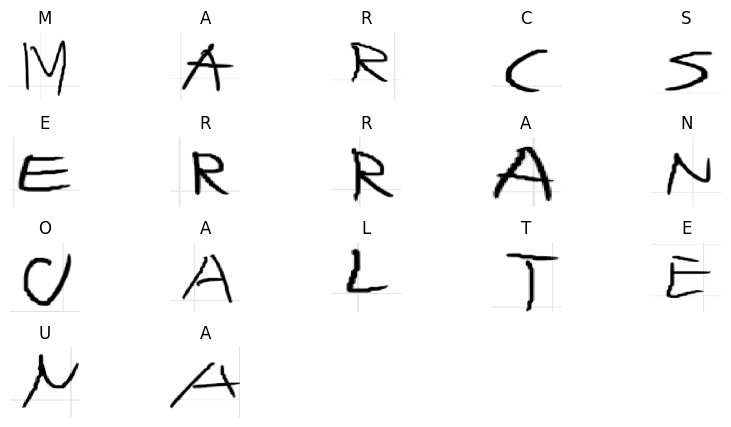

In [20]:
path = dir_path_handwritten_upper
processed_images = load_and_preprocess_images_from_dir(path, target_size=(128, 128), grayscale=True, inverse=inverse)
# processed_image = np.array([X_test[2]])

print(processed_images.shape)

# Make the prediction
predictions = model.predict(processed_images)

# For multi-class classification (e.g., 62 classes):
# Get the index of the class with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

print(processed_images.shape, predicted_classes.shape)
plot_n_images(processed_images, predicted_classes, n=17, row_spacing=0.5)

## Predict your own images

In [21]:
img_path_handwritten_S_blue = os.path.join(base_dir_path, "handwritten_S_blue.jpg")
img_path_handwritten_S_black = os.path.join(base_dir_path, "handwritten_S_black.jpg")
img_path_handwritten_S_far = os.path.join(base_dir_path, "handwritten_S_far.jpg")

img_path_custom = os.path.join(base_dir_path, "S.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
(128, 128)
The model predicted the following character: s


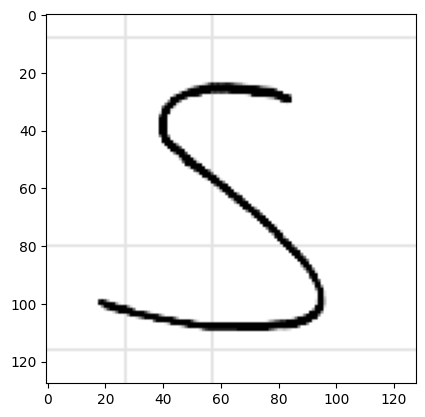

In [22]:
img_path = img_path_custom

processed_image = load_and_preprocess_image(img_path, target_size=(128, 128), grayscale=True, inverse=inverse)
prediction = model.predict(processed_image)
predicted_label = np.argmax(prediction, axis=-1)[0]

processed_image = np.squeeze(processed_image, axis=(0, -1))
print(processed_image.shape)
plt.imshow(processed_image, cmap='gray')
print(f"The model predicted the following character: {label_map[predicted_label]}")